# Clean Metadata
This notebook processes raw metadata provided by GISAID into the format required by Augur. Furthermore, it extracts additional information into unique variables.

## Setup

### Imports

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
import re

# Custom cleaning functions
from data.prep_data.clean_seqs import clean_strain_names
from data.prep_data.clean_seqs import deduplicate

### Files

#### Inputs

In [2]:
input_gisaid = 'h3n2/data/raw/oceania_Jun2018_Now.xls'

#### Outputs



In [3]:
export_augur = 'h3n2/data/clean/oceania_clean.tsv'

### Parameters

## Load raw data from GISAID

In [4]:
meta_raw = pd.DataFrame(pd.read_excel(input_gisaid))
meta_raw.head()

,Isolate_Id,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id,HE Segment_Id,...,PB2 INSDC_Upload,PB1 INSDC_Upload,PA INSDC_Upload,HA INSDC_Upload,NP INSDC_Upload,NA INSDC_Upload,MP INSDC_Upload,NS INSDC_Upload,HE INSDC_Upload,P3 INSDC_Upload
0,EPI_ISL_320399,NaN,NaN,NaN,EPI1269285|N10003747.4,NaN,EPI1270262|N10003747.6,EPI1270263|N10003747.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_ISL_320400,NaN,NaN,NaN,EPI1269286|N10003748.4,NaN,EPI1270321|N10003748.6,EPI1270319|N10003748.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPI_ISL_320405,NaN,NaN,NaN,EPI1269291|N10003753.4,NaN,EPI1270337|N10003753.6,EPI1270334|N10003753.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPI_ISL_336141,NaN,NaN,NaN,EPI1346068|S10010766.4,NaN,EPI1346067|S10010766.6,EPI1346066|S10010766.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EPI_ISL_336142,NaN,NaN,NaN,EPI1346071|S10010767.4,NaN,EPI1346070|S10010767.6,EPI1346069|S10010767.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Keep only the columns we are interested in.

In [5]:
retained_cols = [
    'Isolate_Name',
    'Collection_Date',
    'Isolate_Id',
    'Location',
    'Host',
    'Submitting_Lab',
    'Originating_Lab']

meta_working = meta_raw[retained_cols]

Standardize column name formatting:
- all lowercase
- underscore for word separation (already true)

In [6]:
meta_working.columns = [c.lower() for c in meta_working.columns]

Provide [required columns](https://docs.nextstrain.org/projects/ncov/en/wdl-optionals/analysis/data-prep.html#required-metadata) for Nextstrain.

In [7]:
meta_working = meta_working.rename(
    columns = {
        'isolate_name': 'strain',
        'collection_date': 'date'
    }
)
meta_working['virus'] = 'h3n2_flu'

In [8]:
meta_working.head(n=20)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus
0,A/Sydney/1002/2018,2018-06-08,EPI_ISL_320399,Oceania / Australia / New South Wales / Shell ...,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu
1,A/Perth/1001/2018,2018-06-07,EPI_ISL_320400,Oceania / Australia / Western Australia / Dung...,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu
2,A/Brisbane/73/2018,2018-06-11,EPI_ISL_320405,Oceania / Australia / Queensland / Nambour,Human,WHO Collaborating Centre for Reference and Res...,Queensland Health Forensic and Scientific Serv...,h3n2_flu
3,A/South Australia/176/2018,2018-11-03,EPI_ISL_336141,Oceania / Australia / South Australia / Adelaide,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu
4,A/Victoria/753/2018,2018-11-07,EPI_ISL_336142,Oceania / Australia / Victoria / Pakenham,Human,WHO Collaborating Centre for Reference and Res...,Monash Medical Centre,h3n2_flu
5,A/South Australia/164/2018,2018-11-05,EPI_ISL_336143,Oceania / Australia / South Australia / Woodville,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu
6,A/Sydney/1006/2019,2019-01-14,EPI_ISL_345228,Oceania / Australia / New South Wales / Maitland,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu
7,A/Perth/1000/2019,2019-01-14,EPI_ISL_345229,Oceania / Australia / Western Australia / Clov...,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu
8,A/South Australia/1000/2019,2019-01-10,EPI_ISL_345230,Oceania / Australia / South Australia / Whyalla,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu
9,A/Newcastle/631/2019,2019-03-16,EPI_ISL_353799,Oceania / Australia / New South Wales / Ballina,Human,WHO Collaborating Centre for Reference and Res...,Lismore Base Hospital,h3n2_flu


## Parse metadata

### Parse country

In [9]:
split_columns = meta_working['location'].str.split(' / ', expand=True)
meta_working['region'] = split_columns[0]
meta_working['country'] = split_columns[1]

In [10]:
meta_working.head(n=11)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus,region,country
0,A/Sydney/1002/2018,2018-06-08,EPI_ISL_320399,Oceania / Australia / New South Wales / Shell ...,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu,Oceania,Australia
1,A/Perth/1001/2018,2018-06-07,EPI_ISL_320400,Oceania / Australia / Western Australia / Dung...,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu,Oceania,Australia
2,A/Brisbane/73/2018,2018-06-11,EPI_ISL_320405,Oceania / Australia / Queensland / Nambour,Human,WHO Collaborating Centre for Reference and Res...,Queensland Health Forensic and Scientific Serv...,h3n2_flu,Oceania,Australia
3,A/South Australia/176/2018,2018-11-03,EPI_ISL_336141,Oceania / Australia / South Australia / Adelaide,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu,Oceania,Australia
4,A/Victoria/753/2018,2018-11-07,EPI_ISL_336142,Oceania / Australia / Victoria / Pakenham,Human,WHO Collaborating Centre for Reference and Res...,Monash Medical Centre,h3n2_flu,Oceania,Australia
5,A/South Australia/164/2018,2018-11-05,EPI_ISL_336143,Oceania / Australia / South Australia / Woodville,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu,Oceania,Australia
6,A/Sydney/1006/2019,2019-01-14,EPI_ISL_345228,Oceania / Australia / New South Wales / Maitland,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu,Oceania,Australia
7,A/Perth/1000/2019,2019-01-14,EPI_ISL_345229,Oceania / Australia / Western Australia / Clov...,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu,Oceania,Australia
8,A/South Australia/1000/2019,2019-01-10,EPI_ISL_345230,Oceania / Australia / South Australia / Whyalla,Human,WHO Collaborating Centre for Reference and Res...,Institute of Medical and Veterinary Science (I...,h3n2_flu,Oceania,Australia
9,A/Newcastle/631/2019,2019-03-16,EPI_ISL_353799,Oceania / Australia / New South Wales / Ballina,Human,WHO Collaborating Centre for Reference and Res...,Lismore Base Hospital,h3n2_flu,Oceania,Australia


## Clean dataframe
Clean up values.

Clean strain names
* strip leading and trailing whitespace
* replace spaces with underscores
* replace apostrophes with dashes

In [11]:
meta_working['strain'] = (
    meta_working['strain']
    .apply(lambda x: clean_strain_names(x))
)

In [12]:
meta_working.head(n=11)['strain']

0              A/Sydney/1002/2018
1               A/Perth/1001/2018
2              A/Brisbane/73/2018
3      A/South_Australia/176/2018
4             A/Victoria/753/2018
5      A/South_Australia/164/2018
6              A/Sydney/1006/2019
7               A/Perth/1000/2019
8     A/South_Australia/1000/2019
9            A/Newcastle/631/2019
10            A/Hawkes_Bay/1/2019
Name: strain, dtype: object

### Deduplicate strains

In [13]:
meta_working = deduplicate(meta_working, 'strain')

Originally, there were 4005 records.
	There were 3631 unique records.
	After cleaning, there were 3631 records remaining.


### Clean up countries

In [14]:
meta_working['country'].value_counts(dropna=False)

country
Australia            3088
New Zealand           264
Fiji                   86
Timor-Leste            85
New Caledonia          60
Guam                   13
Vanuatu                12
Tuvalu                 11
Kiribati                5
Wallis and Futuna       4
French Polynesia        3
Name: count, dtype: int64

## Export for Augur
Export tab-delimited file (TSV) for input into Augur.

- Replace `NaN` values with a question mark character (`?`), as preferred by Augur.
- Drop raw columns that have been parsed to new, expanded columns.
- Put columns in preferred order. This is not necessary for Augur, but provides a standard order for my own human reading.
- **Drop duplicate strains.**

In [15]:
col_order = [
    'strain',
    'date',
    'virus',
    'region', 
    'country',
    'host', 
    'isolate_id',
    'submitting_lab',
    'originating_lab']

meta_working = meta_working[col_order]

meta_clean = meta_working.fillna('?')

meta_clean.to_csv(export_augur, sep='\t', index=False, header=False)

## Plot and list all strains by country

### Plot strain counts by country

In [16]:
meta_clean['strain'].count()

3631

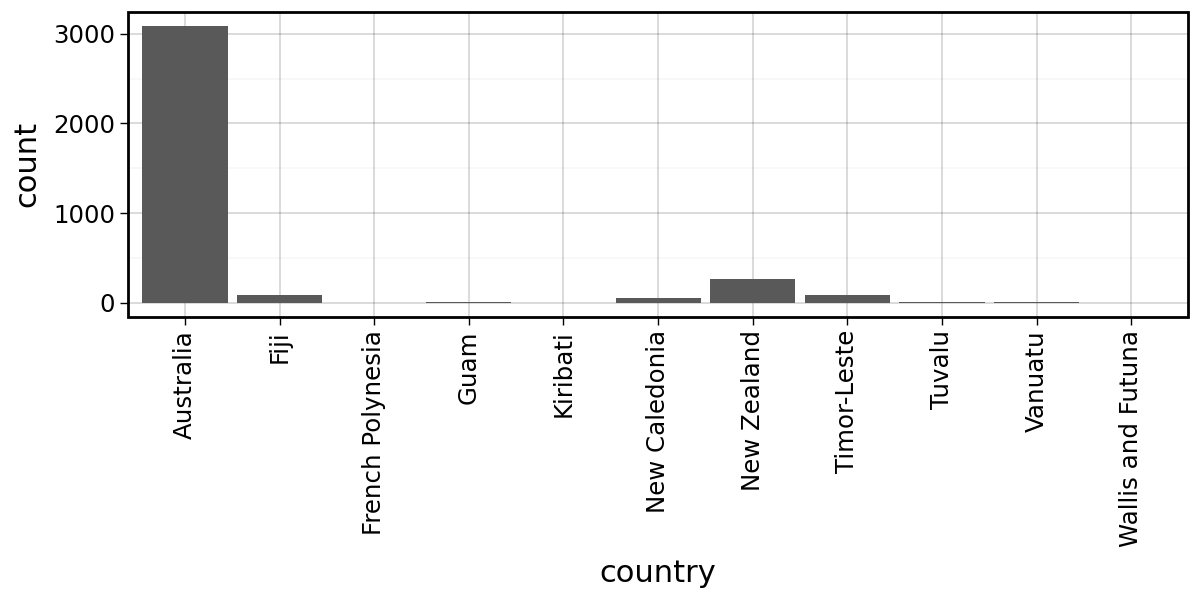

In [17]:
seqs_by_country = (
    p9.ggplot(meta_clean, p9.aes(x='country'))
    + p9.geom_bar()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(6, 3))
)

seqs_by_country


### List strains by country

In [18]:
by_country = meta_working.groupby('country')['strain'].unique()
for key, value in by_country.items():
    print(f"{key} (n={len(value)})")
    for v in value:
        print(v)

Australia (n=3088)
A/Sydney/1002/2018
A/Perth/1001/2018
A/Brisbane/73/2018
A/South_Australia/176/2018
A/Victoria/753/2018
A/South_Australia/164/2018
A/Sydney/1006/2019
A/Perth/1000/2019
A/South_Australia/1000/2019
A/Newcastle/631/2019
A/Sydney/53/2019
A/Newcastle/42/2019
A/Newcastle/50/2019
A/Sydney/35/2019
A/Sydney/45/2019
A/South_Australia/218/2019
A/Newcastle/623/2019
A/Victoria/703/2019
A/Darwin/339/2019
A/Tasmania/1009/2019
A/Darwin/362/2019
A/Canberra/115/2019
A/Canberra/144/2019
A/South_Australia/1060/2019
A/Darwin/394/2019
A/Sydney/82/2019
A/Perth/1051/2019
A/South_Australia/1107/2019
A/Victoria/748/2019
A/Victoria/731/2019
A/Victoria/742/2019
A/Victoria/751/2019
A/South_Australia/255/2019
A/Canberra/124/2019
A/Canberra/145/2019
A/Tasmania/1/2019
A/Tasmania/5/2019
A/Tasmania/15/2019
A/Tasmania/2/2019
A/Tasmania/7/2019
A/Tasmania/8/2019
A/Tasmania/12/2019
A/Tasmania/14/2019
A/Tasmania/16/2019
A/Tasmania/18/2019
A/Tasmania/19/2019
A/Tasmania/20/2019
A/Tasmania/9/2019
A/Tasmania/1